## Imports and Params

In [323]:
from newsapi import NewsApiClient
from nytimesarticle import articleAPI
import pandas_datareader.data as web
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil
import time
import quandl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [324]:
# Params
# extra API keys, comment out as necessary
#api = articleAPI("b23351c6f9314694bfe4f4929a2b72c5") 
#api = articleAPI("787bd4db8e704bbf9cebe8b7941827e0") 
#api = articleAPI("f8b402f42ed14b249fd5accc95a050dd") 
#api = articleAPI("c91a676aeaef40fd844409c8b0bef485")
#api = articleAPI("c43133d654134109868299ff505e7c55")
#api = articleAPI("eb427ebc2336423ead4d350cfa4e900b")
#api = articleAPI("b538de93f1a9459da22b150d7b53cb6f")
api = articleAPI("88f587ed149d4478b4490168d61ed9dc")

quandl.ApiConfig.api_key = "2S7d7eeL5VZrLup9pKg5"
end_date = (datetime.datetime.now() - datetime.timedelta(days=3)).isoformat()
start_date = (datetime.datetime.now() - datetime.timedelta(days=2*365)).isoformat()
left_sources = 'The New York Times'
right_sources = 'Fox News'
center_sources = 'Reuters AP The Wall Street Journal'
all_sources = left_sources + ' ' + right_sources + ' ' + center_sources
replace_list = ['Corp', 'Inc.', 'Inc', '.com', 'plc', ',', 'Co.']
# domain

In [325]:
def main():
    # retrieve s&p 500 companies 
    df = pd.read_csv('constituents_csv.csv')
    companies = df['Name']
    company_symb = {}

    # Iterate through companies
    # for company in companies:
    for i in range(30,31):

        company = companies.loc[i]

        # get company ticker
        company_symb[company] = df[df['Name'] == company]['Symbol']
        ticker = company_symb[company].values[0]
        
        # get rid of suffixes from company name
        for word in replace_list:
            company = company.replace(word, '')

        # initialize the dataframe
        lag = get_lag_period(ticker, start_date, end_date)
        df_current = initialize_dataframe(ticker, start_date, end_date, lag=lag)
        
        # Add sentiment columns in dataframe
        df_current['Pos_t-1'] = 0
        df_current['Neu_t-1'] = 0
        df_current['Neg_t-1'] = 0

        # Query news articles
        trading_dates = df_current.index
        dict_current = query_news_articles(company, start_date, end_date, trading_dates, sources=all_sources)

        # iterate through dates
        for date in dict_current.keys():
            # when you enter seniment into the dataframe, use the before date not after
            average_sentiment_dict = calculate_sentiment(dict_current[date])

            # Plug this into df current
            df_current.at[date,'Pos_t-1'] = average_sentiment_dict['pos']
            df_current.at[date,'Neu_t-1'] = average_sentiment_dict['neu']
            df_current.at[date,'Neg_t-1'] = average_sentiment_dict['neg']
            
        print(i, ticker, 'success')
        #df_current.to_csv('./data/'+ticker+'.csv')
        #df_current = df_current.reset_index()
        return df_current

            # print(i, ticker, 'failed')
            # pass

### Methods Used for Data Collection

In [319]:
def calculate_sentiment(sentence_arr):
    """ Returns the average sentiment of the array
    Params:
        sentence_arr(Array): Array of setences that we have to calculate
        the sentiment of.
    Returns:
        sentiment (dictionary): Takes the average of all sentences
        format of score is {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
    """
    sia = SentimentIntensityAnalyzer()
    df = df = pd.DataFrame(columns=['neg','neu','pos','compound'])
    for sentence in sentence_arr:
        sentiment = sia.polarity_scores(sentence)
        df_sentiment = pd.DataFrame([sentiment], columns=sentiment.keys())
        df = df.append(df_sentiment)
    
    avg_sentiment = dict(df.mean())    
    return avg_sentiment 

In [318]:
def query_news_articles(company, start_date, end_date, trading_dates, sources):
    """ Queries news article for a certain time frame and split it by dates
        Note that
    Params:
        company (String): Name of company
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
         trading_dates (Array of Strings): Array of dates when the market was open
                 dates in format of "2001-12-31"
        sources (Array of Strings): Array of different news sources
    Returns:
        company_dic (dictionary): keys are date, values are array of headlines
    """
    company_dict = {k: [] for k in trading_dates.date}
    start_date = int(start_date.replace("-","").split('T')[0])
    ending_date = (dateutil.parser.parse(end_date)-datetime.timedelta(days=1)).isoformat()
    end_date = int(ending_date.replace("-","").split('T')[0])
    newsdata = api.search(q=company, begin_date = start_date,
                           end_date = end_date,
                          fq='headline:('+company+ ') OR body:('+company+') AND source:(' + sources + ')',
                          page = 0,
                          facet_filter = True)
                               

    #print(newsdata) # newsdata is full HTTP response
    number_of_hits = newsdata['response']['meta']['hits']
    number_of_pages = (number_of_hits // 10) + 1
    
    time.sleep(1)
    # page through results and add headlines to companY_dict
    for i in range(0, min(number_of_pages,200)):
        print('page', i)
        newsdata = api.search(q=company, begin_date = start_date,
                           end_date = end_date,
                          fq='headline:('+company+ ') OR body:('+company+') AND source:(' + sources + ')',
                          page = i,
                          facet_filter = True)
        articles = newsdata['response']['docs']
        for article in articles:
            relevance = article['score']
            if relevance >= 0.005: 
                headline = article['headline']['main']
                blurb = article['snippet']
                # print(article['pub_date'], '\t', article['headline']['main'])
            
                # description = article['description']
                # format of date is 2018-04-13T00:46:59Z (UTC format)
                publish_date = article['pub_date'] 
                print(publish_date)
                # adjust date for trading day
                publish_date, publish_time = publish_date.split('T')
                date_arr = publish_date.split('-')
                publish_datetime = datetime.date(int(date_arr[0]), int(date_arr[1]), int(date_arr[2]))
                time_arr = publish_time[:-1].split(':')
                # stock market closes at 4:00 PM EST; if article published after 
                # 16:00:00+4:00:00 = 20:00:00 UTC headline affects next trading day;
                # otherwise affects current trading day
                trading_datetime = publish_datetime
                if int(time_arr[0]) >= 20:
                    trading_datetime += datetime.timedelta(days=1)
                
                # if given trading_date invalid (ie if article published on Friday 
                # after market close, Saturday, or Sunday before 4 pm est) push trading_date
                # to the following Monday (ie first valid trading_date)
                while trading_datetime not in trading_dates:
                    trading_datetime += datetime.timedelta(1)
                company_dict[trading_datetime].append(headline)
                # company_dict[trading_datetime].append(blurb) include 'snippet' in sentiment analysis
        time.sleep(1)
        
    return company_dict

In [320]:
def get_lag_period(ticker, start_date, end_date):
    """ Finds the optimal lab period given a ticker and the start date and end date
    *** Eventually integrate this into initialize dataframe ***
    Params:
        ticker (String): Stock ticker to be analyzed
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
    Returns:
        lag (int): Number of lag periods
    """
    # Get the data in a dataframe
    dataframe = web.DataReader(ticker, 'morningstar', start_date, end_date)['Close']
    dataframe = pd.Series.to_frame(dataframe)
    dataframe.reset_index(level=0, drop=True, inplace=True)
    dataframe.columns = ['X_t']

    # Fit the model and find optimal lag
    
    # Do k-fold here???
    X = dataframe['X_t']
    train, test = X[:], X[int(len(X)*(0.8)):]
    model = AR(train)
    model_fit = model.fit()
    lag = model_fit.k_ar
    
    return lag
    

In [321]:
# return dataframe with price_t and price_t-1
def initialize_dataframe(ticker, start_date, end_date, lag=1):
    """ Initializes a data frame for a certain ticker
    Params:
        ticker (String): Stock ticker to be analyzed
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
        lag (int): Number of lag periods
    Returns:
        dataframe (pd.Dataframe): Dataframe with index 'Date' ,columns 'X_t' and 'X_t-1'
    """

    # Query quandl for data and make dataframe
    #dataframe = quandl.get('EOD/'+ticker, start_date=start_date, end_date=end_date)['Adj_Close']
    dataframe = web.DataReader(ticker, 'morningstar', 
                               start_date, end_date)['Close']
    
    dataframe = pd.Series.to_frame(dataframe)
    dataframe.reset_index(level=0, drop=True, inplace=True)
    
    # Make columns of dataframe
    dataframe.columns = ['X_t']
    for i in range(lag):
        dataframe['X_t-' + str(i+1)] = dataframe['X_t'].shift(i+1)

    # Remove the first data point because of shift
    dataframe = dataframe.iloc[i+1:]

    return dataframe

In [347]:
def run_backtest_AR(df):
    """ Runs the backtest with k fold cross validation
    Params:
        df (pd.Dataframe): Dataframe with X_t and lags
    Returns:
        dataframe (pd.Dataframe): Dataframe with index 'Date' ,columns 'X_t' and 'X_t-1'
    """

In [414]:
def run_backtest_ADL(df):
    """ Runs the backtest with k fold cross validation
    Params:
        df (pd.Dataframe): Dataframe with X_t, lags, and sentiment score
    Returns:
        dataframe (pd.Dataframe): Dataframe with index 'Date' ,columns 'X_t' and 'X_t-1'
    """
    # Split into 8 different folds
    X = df_test.loc[:, df_test.columns !='X_t']
    Y = df_test['X_t']
    MSE_list = []
    
    split_point = int(len(X) * (1/8))
    X_1 = X[:split_point]
    X_2 = X[split_point:2*split_point]
    X_3 = X[2*split_point:3*split_point]
    X_4 = X[3*split_point:4*split_point]
    X_5 = X[4*split_point:5*split_point]
    X_6 = X[5*split_point:6*split_point]
    X_7 = X[6*split_point:7*split_point]
    X_8 = X[7*split_point:]
    
    Y_1 = Y[:split_point]
    Y_2 = Y[split_point:2*split_point]
    Y_3 = Y[2*split_point:3*split_point]
    Y_4 = Y[3*split_point:4*split_point]
    Y_5 = Y[4*split_point:5*split_point]
    Y_6 = Y[5*split_point:6*split_point]
    Y_7 = Y[6*split_point:7*split_point]
    Y_8 = Y[7*split_point:]
    
    # First Fold Regression
    X_train = pd.concat([X_1, X_2])
    Y_train = pd.concat([Y_1, Y_2])
    X_test = X_3
    Y_test = Y_3
    fit_and_run_regression(X_train, Y_train, X_test, Y_test)

    # Second Fold Regression
    X_train = pd.concat([X_train, X_3])
    Y_train = pd.concat([Y_train, Y_3])
    X_test = X_4
    Y_test = Y_4
    fit_and_run_regression(X_train, Y_train, X_test, Y_test)
    
    # Third Fold Regression
    X_train = pd.concat([X_train, X_4])
    Y_train = pd.concat([Y_train, Y_4])
    X_test = X_5
    Y_test = Y_5
    fit_and_run_regression(X_train, Y_train, X_test, Y_test)
    
    # Fourth Fold Regression
    X_train = pd.concat([X_train, X_5])
    Y_train = pd.concat([Y_train, Y_5])
    X_test = X_6
    Y_test = Y_6
    fit_and_run_regression(X_train, Y_train, X_test, Y_test)
    
    # Fifth Fold Regression
    X_train = pd.concat([X_train, X_6])
    Y_train = pd.concat([Y_train, Y_6])
    X_test = X_7
    Y_test = Y_7
    fit_and_run_regression(X_train, Y_train, X_test, Y_test)
    
    # Sixth Fold Regression
    X_train = pd.concat([X_train, X_7])
    Y_train = pd.concat([Y_train, Y_7])
    X_test = X_8
    Y_test = Y_8
    fit_and_run_regression(X_train, Y_train, X_test, Y_test)

In [417]:
def fit_and_run_regression(X_train, Y_train, X_test, Y_test):
    """ Fits the model with train and test data
    Params:
        X_train (pd.Dataframe): X training data
        Y_train (pd.Dataframe): Y training data
    Returns:
        MSE (float): Mean Squared Error 
    """
    LinReg = LinearRegression(normalize=True)
    LinReg.fit(X_train,Y_train)
    Y_pred = LinReg.predict(X_test)
    MSE = mean_squared_error(Y_test, Y_pred)
    print("R^2 Value: %.2f" %LinReg.score(X_test, Y_test))
    print("Mean squared error: %.2f "% MSE)
    print("Coefficients for the Regression are: " ,LinReg.coef_)
    
    return MSE

In [418]:
run_backtest_ADL(df_sentiment)




R^2 Value: 0.88
Mean squared error: 111.53 
Coefficients for the Regression are:  [ 0.94624589  0.07470879 -0.08351212 -0.06905889  0.11001847  0.08109859
 -0.17405023  0.11315158  0.07109341 -0.01059149  0.0837274  -0.36339553
  0.07374385  0.02881764  0.16462825 -0.21790443  0.13796012]
R^2 Value: 0.95
Mean squared error: 73.54 
Coefficients for the Regression are:  [ 1.00811635 -0.00301733 -0.09254623 -0.00694217  0.05095211  0.09214457
 -0.18304821  0.06221602  0.02050813  0.13047056 -0.0077407  -0.1671551
  0.10336911  0.04241289 -0.06526269 -0.11723243  0.10493455]
R^2 Value: 0.74
Mean squared error: 143.81 
Coefficients for the Regression are:  [ 1.03340405 -0.02401035 -0.08898881  0.02938177  0.06531181  0.01447147
 -0.16959171  0.10187151  0.01275307  0.10208298 -0.02309355 -0.14141191
  0.12123944  0.01110608 -0.02929923 -0.11912777  0.10899718]
R^2 Value: 0.77
Mean squared error: 356.01 
Coefficients for the Regression are:  [ 1.0330485  -0.06467204  0.00231037  0.01421793 -

### Try AR Regression without the package

In [335]:
# Try normal linear regression using lag period lags
lag = get_lag_period('AMZN', start_date, end_date)
print('Number of lags:',lag)
df_test = initialize_dataframe('AMZN', start_date, end_date, lag)
df_test.head()

Y = df_test['X_t']
X = df_test.loc[:, df_test.columns !='X_t']
X_train, X_test = X[:int(len(X)*(0.8))], X[int(len(X)*(0.8)):]
Y_train, Y_test = Y[:int(len(Y)*(0.8))], Y[int(len(Y)*(0.8)):]

LinReg = LinearRegression(normalize=True)
LinReg.fit(X_train,Y_train)
Y_pred = LinReg.predict(X_test)
print("R^2 Value: %.2f" %LinReg.score(X_test, Y_test))
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
print("Coefficients for the Regression are: " ,LinReg.coef_)

Number of lags: 17
R^2 Value: 0.95
Mean squared error: 770.13
Coefficients for the Regression are:  [ 1.04588218 -0.10186545  0.03731649 -0.05776646  0.07091955 -0.01462105
 -0.05719106  0.06532265 -0.04445096  0.08884507 -0.02127526 -0.02848972
 -0.00857457  0.0628712  -0.04517304 -0.01750931  0.0284214 ]


             Actual    Predicted
Date                            
2017-12-15  1179.14  1176.935505
2017-12-18  1190.58  1179.200963
2017-12-19  1187.38  1190.319602
2017-12-20  1177.62  1188.199976
2017-12-21  1174.76  1180.804041


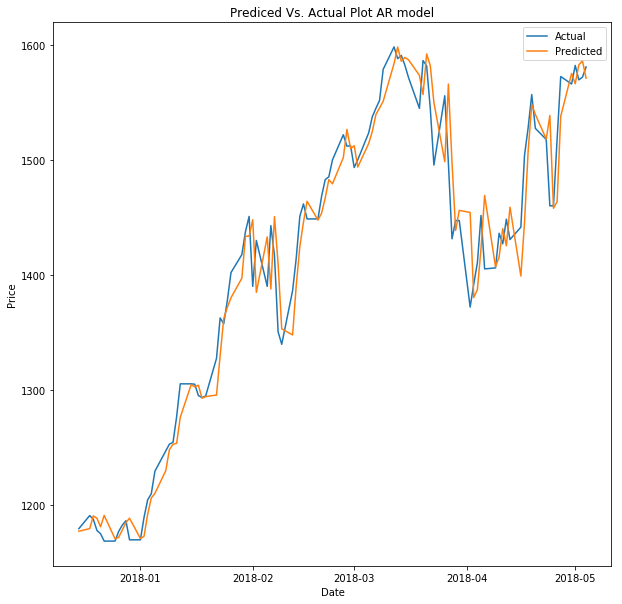

In [344]:
Y_plot = Y_test.copy(deep=True)
Y_plot = Y_plot.to_frame()
Y_plot['Predicted'] = pd.Series(Y_pred, index=Y_plot.index)
Y_plot.columns = ['Actual', 'Predicted']
print(Y_plot.head())

plt.figure(figsize=(10,10))
plt.title('Predicted Vs. Actual Plot AR model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(Y_plot.index, Y_plot['Actual'], label='Actual')
plt.plot(Y_plot.index, Y_plot['Predicted'],label='Predicted')
plt.legend()

plt.show()

### Try Regression with sentiment analysis

In [341]:
df_sentiment = main()
df_sentiment.head()

page 0
2018-05-03T18:54:19+0000
2018-01-25T18:11:56+0000
2018-04-27T04:01:41+0000
2018-04-04T09:11:09+0000
2018-03-29T10:40:59+0000
2018-05-03T09:45:05+0000
2018-04-18T23:16:31+0000
2018-03-15T23:20:22+0000
2018-01-30T12:22:10+0000
2017-10-26T21:45:11+0000
page 1
2018-01-28T19:30:49+0000
2018-03-29T15:46:12+0000
2018-03-23T17:10:19+0000
2018-04-06T12:00:01+0000
2017-12-21T20:23:49+0000
2017-11-16T21:08:18+0000
2017-07-20T09:00:38+0000
2017-08-24T14:19:01+0000
2017-03-27T16:01:10+0000
2017-08-17T00:10:18+0000
page 2
2017-05-01T18:37:35+0000
2017-07-13T14:21:16+0000
2017-06-29T13:30:17+0000
2017-03-31T18:20:20+0000
2018-03-19T22:08:41+0000
2018-04-24T14:00:07+0000
2017-05-19T11:00:33+0000
2018-03-16T09:57:09+0000
2018-03-04T16:34:40+0000
2018-04-20T09:53:03+0000
page 3
2017-09-15T14:21:28+0000
2018-04-16T13:16:28+0000
2017-04-06T16:16:01+0000
2017-03-30T18:24:46+0000
page 4
page 5
page 6
page 7
page 8
page 9
page 10
page 11
page 12
page 13
page 14
page 15
page 16
page 17
page 18
page 19


,X_t,X_t-1,X_t-2,X_t-3,X_t-4,X_t-5,X_t-6,X_t-7,X_t-8,X_t-9,...,X_t-11,X_t-12,X_t-13,X_t-14,X_t-15,X_t-16,X_t-17,Pos_t-1,Neu_t-1,Neg_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,719.44,722.79,712.24,712.24,714.91,708.35,704.20,696.75,702.80,698.52,...,695.27,710.66,709.92,717.93,713.23,703.07,679.75,NaN,NaN,NaN
2016-06-02,728.24,719.44,722.79,712.24,712.24,714.91,708.35,704.20,696.75,702.80,...,697.45,695.27,710.66,709.92,717.93,713.23,703.07,NaN,NaN,NaN
2016-06-03,725.54,728.24,719.44,722.79,712.24,712.24,714.91,708.35,704.20,696.75,...,698.52,697.45,695.27,710.66,709.92,717.93,713.23,NaN,NaN,NaN
2016-06-06,726.73,725.54,728.24,719.44,722.79,712.24,712.24,714.91,708.35,704.20,...,702.80,698.52,697.45,695.27,710.66,709.92,717.93,NaN,NaN,NaN
2016-06-07,723.74,726.73,725.54,728.24,719.44,722.79,712.24,712.24,714.91,708.35,...,696.75,702.80,698.52,697.45,695.27,710.66,709.92,NaN,NaN,NaN


In [345]:
# Do the regression sentiment

# Count number of nulls and replace them with 0's
df_sentiment.isnull().sum()
df_sentiment = df_sentiment.fillna(0)
df_sentiment.head()

Y = df_sentiment['X_t']
X = df_sentiment.loc[:, df_sentiment.columns !='X_t']
X_train, X_test = X[:int(len(X)*(0.8))], X[int(len(X)*(0.8)):]
Y_train, Y_test = Y[:int(len(Y)*(0.8))], Y[int(len(Y)*(0.8)):]

LinReg_sentiment = LinearRegression(normalize=True)
LinReg_sentiment.fit(X_train,Y_train)
Y_pred = LinReg_sentiment.predict(X_test)
print("R^2 Value: %.2f" %LinReg_sentiment.score(X_test, Y_test))
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
print("Coefficients for the Regression are: " , LinReg_sentiment.coef_)

R^2 Value: 0.95
Mean squared error: 784.83
Coefficients for the Regression are:  [ 1.04278315e+00 -1.11890609e-01  4.46964615e-02 -4.60403434e-02
  6.18420744e-02 -1.33650521e-02 -5.48876793e-02  7.95916683e-02
 -5.61641689e-02  8.69321269e-02 -2.51384855e-02 -1.00611621e-02
 -3.37231812e-02  5.76411040e-02 -2.03305487e-02 -2.49173842e-02
  2.57103631e-02  2.75494385e+01  1.14703775e+01 -8.59599750e+01]


             Actual    Predicted
Date                            
2017-12-15  1179.14  1176.935505
2017-12-18  1190.58  1179.200963
2017-12-19  1187.38  1190.319602
2017-12-20  1177.62  1188.199976
2017-12-21  1174.76  1180.804041


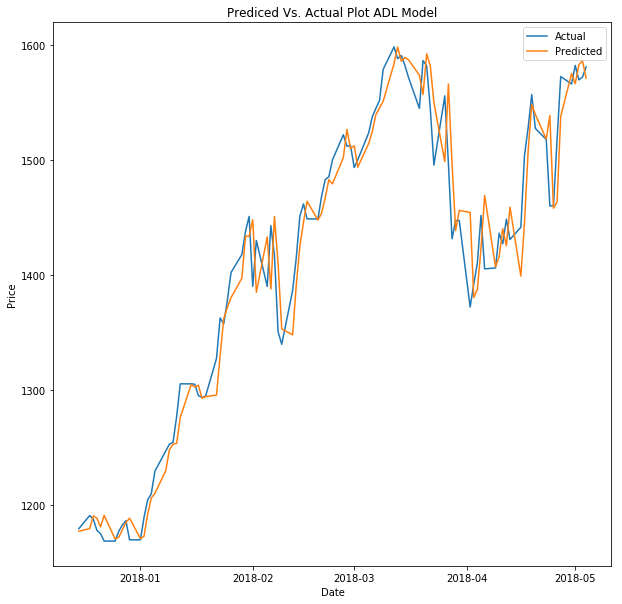

In [346]:
# Plot
Y_plot = Y_test.copy(deep=True)
Y_plot = Y_plot.to_frame()
Y_plot['Predicted'] = pd.Series(Y_pred, index=Y_plot.index)
Y_plot.columns = ['Actual', 'Predicted']
print(Y_plot.head())

plt.figure(figsize=(10,10))
plt.title('Predicted Vs. Actual Plot ADL Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(Y_plot.index, Y_plot['Actual'], label='Actual')
plt.plot(Y_plot.index, Y_plot['Predicted'],label='Predicted')
plt.legend()

plt.show()

## Regression

In [102]:
# Run to get amazon's df
df_current = main()
df_current.head()


30 AMZN success


,X_t,X_t-1,Pos_t-1,Neu_t-1,Neg_t-1
Date,,,,,
2016-05-10,703.07,679.75,NaN,NaN,NaN
2016-05-11,713.23,703.07,NaN,NaN,NaN
2016-05-12,717.93,713.23,NaN,NaN,NaN
2016-05-13,709.92,717.93,NaN,NaN,NaN
2016-05-16,710.66,709.92,NaN,NaN,NaN


In [104]:
# Find index of earlier data
df_current.loc[datetime.datetime(2018,2,7)]
# df_current.loc[df_current['Date'] == datetime.datetime(2018,2,7)]

X_t        1416.78000
X_t-1      1442.84000
Pos_t-1       0.19500
Neu_t-1       0.75050
Neg_t-1       0.05425
Name: 2018-02-07 00:00:00, dtype: float64

In [105]:
# Use this to splice the dataframe to 2018-02-07 and after
df_changed = df_current[456:].fillna(0)
df_changed.head()

,X_t,X_t-1,Pos_t-1,Neu_t-1,Neg_t-1
Date,,,,,
2018-02-07,1416.78,1442.84,0.195000,0.750500,0.054250
2018-02-08,1350.50,1416.78,0.100200,0.856200,0.043400
2018-02-09,1339.60,1350.50,0.163250,0.760250,0.076500
2018-02-12,1386.23,1339.60,0.180000,0.779500,0.040375
2018-02-13,1414.51,1386.23,0.126667,0.755667,0.117667


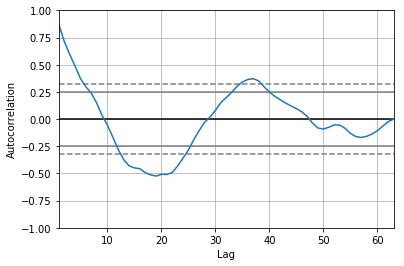

In [110]:
# Plot autocorrelation values
plt.figure()
autocorrelation_plot(df_changed['X_t'])
plt.show()

In [306]:
# Split into train and test
X = df_changed['X_t']
train, test = X[:int(len(X)*(0.8))], X[int(len(X)*(0.8)):]
# Fit the model
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 10
Coefficients: const      312.890808
L1.X_t       0.657682
L2.X_t       0.044595
L3.X_t       0.447120
L4.X_t       0.087561
L5.X_t      -0.299498
L6.X_t      -0.056794
L7.X_t      -0.055210
L8.X_t       0.208179
L9.X_t      -0.237377
L10.X_t     -0.004924
dtype: float64


In [307]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
R2 = r2_score(test, predictions)
print('Test R^2 Score: %.3f ' % R2)

predicted=1487.170320, expected=1527.840000
predicted=1485.680652, expected=1556.910000
predicted=1523.658735, expected=1527.490000
predicted=1534.124799, expected=1517.860000
predicted=1528.772591, expected=1460.090000
predicted=1534.694456, expected=1460.170000
predicted=1550.634488, expected=1517.960000
predicted=1560.056127, expected=1572.620000
predicted=1545.616663, expected=1566.130000
predicted=1546.435300, expected=1582.260000
predicted=1558.232553, expected=1569.680000
predicted=1548.752875, expected=1572.075000
predicted=1534.306438, expected=1580.950000
Test MSE: 1773.717
Test R^2 Score: -0.076 


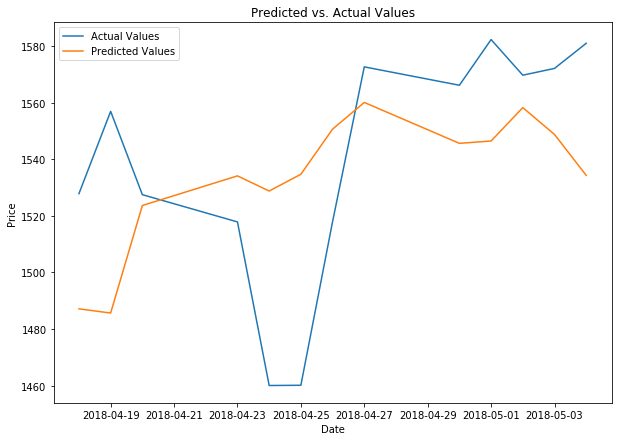

In [308]:
# Plot the preditions
plt.figure(figsize=(10,7))
plt.plot(test, label='Actual Values')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.show()